In [44]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals



%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
# These steps are typically always called.  The "matplotlib inline" is to display figures in this notebook itself 


import pandas as pd 
# pandas is a library for handling datasets; you will see some useful built-in functions in action

import os # to move around your operating system

import scipy as sp  # scientific computation library

from mpl_toolkits.mplot3d import axes3d # in case we need to plot in 3D z=f(x,y)
import seaborn as sns  # another package for pretty graphs

# Scikit-learn (sklearn) is a powerful and fairly comprehensive library of ML algorithms

from sklearn import datasets
from sklearn.neighbors.kde import KernelDensity
from sklearn import linear_model

In [76]:
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('iris.data', header=None)
df.head()

columns=['sepal length', 'sepal width', 'petal width', 'petal length']

classes = np.unique(df[4].values).tolist()
classes

     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa


In [49]:
# d_class[0] is class iris-setosa
# d_class[1] is class iris-versicolor
# d_class[2] is class iris-virginica
data_class = {0: df[df[4] == 'Iris-setosa']._get_numeric_data(),
           1: df[df[4] == 'Iris-versicolor']._get_numeric_data(),
           2: df[df[4] == 'Iris-virginica']._get_numeric_data()}

data_class[1].index=range(0,len(d_class[1]))
data_class[2].index=range(0,len(d_class[2]))

def classMean(setosa, versicolor, virginica):
    meanClass = []
    for i in range(4):
         meanClass.insert(i, (setosa[i]+versicolor[i]+virginica[i])/3)
    
    return meanClass


In [65]:
data={k: np.array([list(d_class[k].loc[i,: ]) for i in range(50)]) for k in range(3)}

In [66]:
for i in range(3):
    Smean[i]= np.mean(data[i], axis=0)
    
Smean

[array([5.006, 3.418, 1.464, 0.244]),
 array([5.936, 2.77 , 4.26 , 1.326]),
 array([6.588, 2.974, 5.552, 2.026])]

In [67]:
meanMean = np.mean(np.array(Smean), axis=0)
meanMean

array([5.84333333, 3.054     , 3.75866667, 1.19866667])

In [70]:
def covariance_mean(Smean, mean):
    s = mean.shape[0]
    
    return np.dot((Smean - mean).reshape(s,1), (Smean - mean).reshape(1,s))

SB = np.zeros((4,4))
for k in range(3):
    SB+= covariance_mean(Smean[k], meanMean)
    
print(SB)

[[ 1.26424267 -0.39068     3.30329333  1.42726133]
 [-0.39068     0.219552   -1.121104   -0.449848  ]
 [ 3.30329333 -1.121104    8.73287467  3.73816267]
 [ 1.42726133 -0.449848    3.73816267  1.61208267]]


In [71]:
iris_setosa = data[0]
iris_versicolor = data[1]
iris_virginica = data[2]


def calculateCovariance(data, Smean, k):
    covariance = np.zeros((4, 4))
    for i in range(data.shape[0]):
        covariance+= ((data[i,:] - Smean[k]).reshape(4, 1).dot((data[i,:] - Smean[k]).reshape(1, 4)))
        
    return covariance

covarianceSetosa = calculateCovariance(iris_setosa, Smean, 0)
covarianceVersicolor = calculateCovariance(iris_versicolor, Smean, 1)
covarianceVirginica = calculateCovariance(iris_virginica, Smean, 2)

SW = covarianceSetosa + covarianceVersicolor + covarianceVirginica

print(SW)

[[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [73]:
# generalized eigenvalue problem Sb*v = lambda*Sw*v
det = np.linalg.det(SW)
det

22069.109168675746

SW is invertible which means:  
\begin{equation*}
S_W^{-1} S_B :  S_W^{-1} S_B v = λv .
\end{equation*}

In [77]:
P=np.dot(np.linalg.inv(SW), SB)
print(P)
lam, V = np.linalg.eigh(P)

[[-0.06049419  0.02097089 -0.16037413 -0.06849721]
 [-0.1124181   0.04304984 -0.3021683  -0.12765321]
 [ 0.16057915 -0.05730874  0.42737317  0.18196891]
 [ 0.21334399 -0.06826502  0.5598107   0.24106167]]


P has the eigenvalues

In [78]:
lam

array([-0.26024645, -0.14268993,  0.07235097,  0.9815759 ])

and the corresponding eigenvectors are the column in the numpy array V.

In [79]:
V

array([[ 0.43122748,  0.77595698, -0.38420452,  0.25361489],
       [ 0.08952333,  0.43033621,  0.89010784, -0.12043398],
       [ 0.50890581, -0.40027793,  0.24019528,  0.72325561],
       [-0.73962376,  0.22908315,  0.04900146,  0.63093301]])

Get the position of the maximal eigenvalue

In [80]:
maxValue = np.argmax(lam)

In [81]:
w = V[:, maxValue]
np.linalg.norm(w)

0.9999999999999999

In [82]:
w

array([ 0.25361489, -0.12043398,  0.72325561,  0.63093301])

In [83]:
def project_data(data, v):
   
    w=v/np.linalg.norm(v)
    coord_pr_data=data.dot(w)# w^T x with x in data
    
    return coord_pr_data

In [84]:
project_data0 = project_data(data[0], w)
project_data1 = project_data(data[1], w)
project_data2 = project_data(data[2], w)

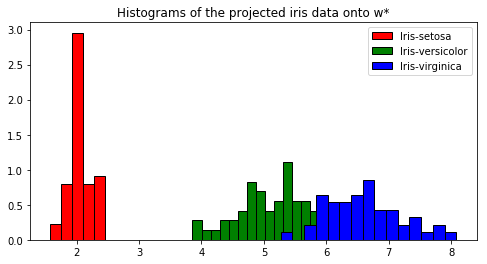

In [103]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
h0 = ax.hist(project_data0, bins=5, density=True, color='r', ec='black', label=classes[0])
h1 = ax.hist(project_data1, bins=15, density=True, color='g', ec='black', label=classes[1])
h2 = ax.hist(project_data2, bins=15, density=True, color='b', ec='black', label=classes[2])
ax.set_title("Histograms of the projected iris data onto w*")
leg=ax.legend(loc='upper right')

In [95]:
lam

array([-0.26024645, -0.14268993,  0.07235097,  0.9815759 ])

In [96]:
V

array([[ 0.43122748,  0.77595698, -0.38420452,  0.25361489],
       [ 0.08952333,  0.43033621,  0.89010784, -0.12043398],
       [ 0.50890581, -0.40027793,  0.24019528,  0.72325561],
       [-0.73962376,  0.22908315,  0.04900146,  0.63093301]])

In [97]:
a = V[:, 1]
a

array([ 0.77595698,  0.43033621, -0.40027793,  0.22908315])

In [98]:
unoptimalW = np.add(w, a)
unoptimalW

array([1.02957187, 0.30990223, 0.32297768, 0.86001616])

In [99]:
proj_data_unoptimalW0 = project_data(data[0], unoptimalW)
proj_data_unoptimalW1 = project_data(data[1], unoptimalW)
proj_data_unoptimalW2 = project_data(data[2], unoptimalW)

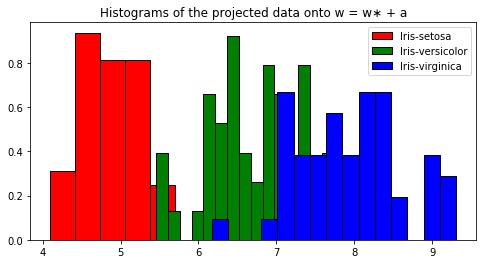

In [100]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111) 
h0 = ax.hist(proj_data_unoptimalW0, bins=5, density=True, color='r', ec='black', label=classes[0])
h1 = ax.hist(proj_data_unoptimalW1, bins=15, density=True, color='g', ec='black', label=classes[1])
h2 = ax.hist(proj_data_unoptimalW2, bins=15, density=True, color='b', ec='black', label=classes[2])
ax.set_title("Histograms of the projected data onto w = w∗ + a")
leg=ax.legend(loc='upper right')

In [101]:
project_data_a0 = project_data(data[0], a)
project_data_a1 = project_data(data[1], a)
project_data_a2 = project_data(data[2], a)

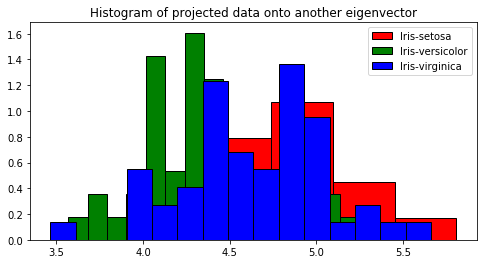

In [102]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
h0 = ax.hist(project_data_a0, bins=5, density=True, color='r', ec='black', label=classes[0])
h1 = ax.hist(project_data_a1, bins=15, density=True, color='g', ec='black', label=classes[1])
h2 = ax.hist(project_data_a2, bins=15, density=True, color='b', ec='black', label=classes[2])
ax.set_title("Histogram of projected data onto another eigenvector")
leg=ax.legend(loc='upper right')